In [1]:
%load_ext autoreload
%autoreload 2
import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent.parent))

In [2]:
%reload_ext dotenv

%dotenv ../../env/.env

import warnings
from pandas import Timedelta
# from optiml.utils import sf
import time
from optiml.utils.sf import logger, sql_to_df, run_sql, conn, session
import pandas as pd
warnings.filterwarnings('ignore')

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime


connected to account OMWYKHW-US_WEST_2 wh DEMO db SHARE_COPY schema KNOT_MONITORING with role DEV
time: 27.4 ms (started: 2023-06-03 23:20:21 -04:00)


In [12]:
print(wh_profile_sim)



with sim_snowflake_suspend as (
select 
    *,
    (active_hours - idle_hours)*60 as query_minutes,
    idle_hours * 60 as idle_minutes
from warehouse_profile_by_hour_sim
where warehouse_name = 'SEGMENT_LOAD_WH' 
and hour_start > dateadd('days',-$lookback_days, current_timestamp())
and strategy = {'autosuspend_sec': 60,   'engine': 'sql',   'type': 'snowflake' }
),
sim_aero_managed as (
select 
    *,
    (active_hours - idle_hours)*60 as query_minutes,
    idle_hours * 60 as idle_minutes
from warehouse_profile_by_hour_sim
where warehouse_name = 'SEGMENT_LOAD_WH' 
and hour_start > dateadd('days',-$lookback_days, current_timestamp())
and strategy = {'engine': 'python',   'polling_sec': 1,   'type': 'greedy_after_one_min' }
),

actual as (
    select 
        *,
        (active_hours - idle_hours)*60 as query_minutes,
        idle_hours * 60 as idle_minutes
    from warehouse_profile_by_hour
    where warehouse_name = 'SEGMENT_LOAD_WH' 
    and hour_start > dateadd('days',-$lookback_da

In [14]:
run_sql("set lookback_days=4")

wh_name = 'SEGMENT_LOAD_WH'
wh_profile = f"""
select 
    *,
    (active_hours - idle_hours)*60 as query_minutes,
    idle_hours * 60 as idle_minutes
from warehouse_profile_by_hour
where warehouse_name = '{wh_name}' 
and hour_start > dateadd('days',-$lookback_days, current_timestamp())
order by hour_start desc;
"""

import itables


wpdf = sql_to_df(wh_profile)
itables.show(wpdf)


wh_profile_sim = f"""

with sim_snowflake_suspend as (
select 
    *,
    (active_hours - idle_hours)*60 as query_minutes,
    idle_hours * 60 as idle_minutes
from warehouse_profile_by_hour_sim
where warehouse_name = '{wh_name}' 
and hour_start > dateadd('days',-$lookback_days, current_timestamp())
and strategy = {{'autosuspend_sec': 60,   'engine': 'sql',   'type': 'snowflake' }}
),
sim_aero_managed as (
select 
    *,
    (active_hours - idle_hours)*60 as query_minutes,
    idle_hours * 60 as idle_minutes
from warehouse_profile_by_hour_sim
where warehouse_name = '{wh_name}' 
and hour_start > dateadd('days',-$lookback_days, current_timestamp())
and strategy = {{'engine': 'python',   'polling_sec': 1,   'type': 'greedy_after_one_min' }}
),

actual as (
    select 
        *,
        (active_hours - idle_hours)*60 as query_minutes,
        idle_hours * 60 as idle_minutes
    from warehouse_profile_by_hour
    where warehouse_name = '{wh_name}' 
    and hour_start > dateadd('days',-$lookback_days, current_timestamp())
)
select
    a.*,
    a.query_minutes as query_minutes_actual,
    a.idle_minutes as idle_minutes_actual,
    s.query_minutes as query_minutes_sim_snowflake,
    s.idle_minutes as idle_minutes_sim_snowflake,
    m.query_minutes as query_minutes_sim_aero,
    m.idle_minutes as idle_minutes_sim_aero,
    
   (abs(idle_minutes_sim_aero - idle_minutes_actual) < abs(idle_minutes_sim_snowflake - idle_minutes_actual)) as aero_presumed_on,
    sum( case when aero_presumed_on then  (idle_minutes_sim_snowflake - idle_minutes_actual ) else 0 end) over (order by a.hour_start asc) as cum_idle_minutes_saved,
   sum( case when aero_presumed_on then  a.max_cluster_number * (idle_minutes_sim_snowflake - idle_minutes_actual ) else 0  end) over (order by a.hour_start asc) as cum_cluster_idle_minutes_saved,
   sum(aero_presumed_on::int) over (order by a.hour_start asc) as hours_on,
   (cum_idle_minutes_saved / 60) * wc.credits_per_hour as cum_credits_saved_pessimistic,
   (cum_cluster_idle_minutes_saved / 60) * wc.credits_per_hour as cum_credits_saved_upperbound,
   div0(cum_credits_saved_pessimistic * (365 * 24), hours_on) as annualized_credits_saved_projected_pessimistic,
   div0(cum_credits_saved_upperbound * (365 * 24), hours_on) as annualized_credits_saved_projected_upperbound
        
    
from actual a
left join sim_snowflake_suspend s
on a.hour_start = s.hour_start
left join sim_aero_managed m
on a.hour_start = m.hour_start
left join warehouse_credits wc
on a.warehouse_size = wc.size
order by hour_start desc;

"""
wpsimdf = sql_to_df(wh_profile_sim)


wh_events = f"""
select 
    current_timestamp(), 
    *,
    event_reason || ':' || nvl(role_name, 'null') as source
from stg_warehouse_events_history 
where event_name = 'SUSPEND_WAREHOUSE'
and event_state = 'COMPLETED'
and warehouse_name='{wh_name}' 
and timestamp > dateadd('days',-$lookback_days, current_timestamp())
order by timestamp desc;
"""


wedf = sql_to_df(wh_events)
itables.show(wedf)


op_queries = """
select
    start_time,
    query_text,
    credits_used_cloud_services,
    cloud_services_cost,
    cloud_services_cost/credits_used_cloud_services as dollars_per_credit,
    sum(credits_used_cloud_services) over (order by start_time asc) cum_credits_used_cloud_services,
    sum(query_cost) over (order by start_time asc) cum_query_cost
from query_history_enriched
where (contains(lower(user_name), 'aero') or contains(lower(user_name), 'optiml'))
and (contains(lower(query_text), 'show warehouses') or contains(lower(query_text), 'alter warehouse'))
and start_time > dateadd('days',-$lookback_days, current_timestamp());
"""


opdf = sql_to_df(op_queries)
itables.show(opdf)

suspension_stats = """
with eras as (
    select
        'query' as type,
        warehouse_id,
        warehouse_name,
        warehouse_sizes,
        max_cluster_number,
        era_start,
        era_end
    from query_era
    where era_end <= (select max(era_end) from warehouse_era)
    
    union

    select
        'warehouse'as type,
        warehouse_id,
        warehouse_name,
        null as max_cluster_number,
        null as warehouse_sizes,
        era_start,
        era_end
    from warehouse_era
    where era_start > (select min(era_start) from query_era)
    and era_end <= (select max(era_end) from query_era)
),
enriched as (
    select 
        row_number() over(order by warehouse_id, era_end) as era_id,
        *,
        -- max(era_end) over (partition by warehouse_id)
        lag(type) over (partition by warehouse_id order by era_end) as previous_ending_type,
        lag(era_end) over (partition by warehouse_id order by era_end) as previous_ending_time,
        lag(max_cluster_number) over (partition by warehouse_id order by era_end) as previous_max_cluster_number,
        lag(warehouse_sizes) over (partition by warehouse_id order by era_end) as prevous_wh_sizes,
        case when type = 'warehouse' and previous_ending_type = 'query' then timediff(milliseconds, previous_ending_time, era_end)/1000 else null end as suspend_lag,
        case when type = 'query' and previous_ending_type = 'query' then timediff(milliseconds, previous_ending_time, era_start)/1000 else null end as time_since_last_query,
        timediff(seconds, era_start, era_end) as era_seconds
    from eras
)
-- select * from enriched order by era_end desc limit 10;
,
suspends as (
select
    warehouse_id,
    warehouse_name,
    prevous_wh_sizes as warehouse_sizes,
    previous_max_cluster_number,
    era_end as suspend_time,
    suspend_lag
from enriched
where suspend_lag is not null
),
suspension_hour_stats as (
-- select * from suspends limit 10;
select
	warehouse_id,
    warehouse_name,
    date_trunc('hour', suspend_time) as hour,
    array_union_agg(warehouse_sizes) as sizes,
    sizes[0]::text as size,
    max(previous_max_cluster_number) as clusters,
    count(*) as num_suspensions,
    sum(previous_max_cluster_number*(60 - suspend_lag)) as max_saved_idle_seconds,
    avg(suspend_lag) suspend_lag_avg,
    median(suspend_lag) suspend_lag_median,
    min(suspend_lag) suspend_lag_min,
    percentile_cont(.99) within group(order by suspend_lag) as "99_pctile",
    max(suspend_lag) suspend_lag_max
from suspends s
where warehouse_name = 'SEGMENT_LOAD_WH'
and suspend_time > dateadd('days',-$lookback_days, current_timestamp())
group by 1,2,3
),
suspension_savings as (
select 
    s.*,
    max_saved_idle_seconds * wc.credits_per_hour / 3600 as max_credit_diff,
    max_credit_diff * 3 as max_dollar_diff,
    sum(max_dollar_diff) over(order by hour asc) as cum_savings
from 
    suspension_hour_stats s
left join warehouse_credits wc
on s.size = wc.size
)
select * from suspension_savings
order by hour desc;
"""

sdf = sql_to_df(suspension_stats)
itables.show(sdf)


time: 9.1 s (started: 2023-06-03 23:55:14 -04:00)


In [15]:
wpsimdf.columns

Index(['warehouse_id', 'warehouse_name', 'warehouse_sizes', 'warehouse_size',
       'max_cluster_number', 'hour_start', 'active_hours', 'billed_hours',
       'idle_hours', 'pct_idle', 'credits_used_compute',
       'dollars_used_compute', 'credits_used_single_cluster_inferred',
       'dollars_used_single_cluster_inferred', 'dollars_used_idle',
       'query_minutes', 'idle_minutes', 'query_minutes_actual',
       'idle_minutes_actual', 'query_minutes_sim_snowflake',
       'idle_minutes_sim_snowflake', 'query_minutes_sim_aero',
       'idle_minutes_sim_aero', 'aero_presumed_on', 'cum_idle_minutes_saved',
       'cum_cluster_idle_minutes_saved', 'hours_on',
       'cum_credits_saved_pessimistic', 'cum_credits_saved_upperbound',
       'annualized_credits_saved_projected_pessimistic',
       'annualized_credits_saved_projected_upperbound'],
      dtype='object')

time: 2.75 ms (started: 2023-06-03 23:55:47 -04:00)


In [41]:
%%markdown
# Idle Time, Suspension Lag, Savings Estimates

# Idle Time, Suspension Lag, Savings Estimates


time: 2.68 ms (started: 2023-06-04 00:07:36 -04:00)


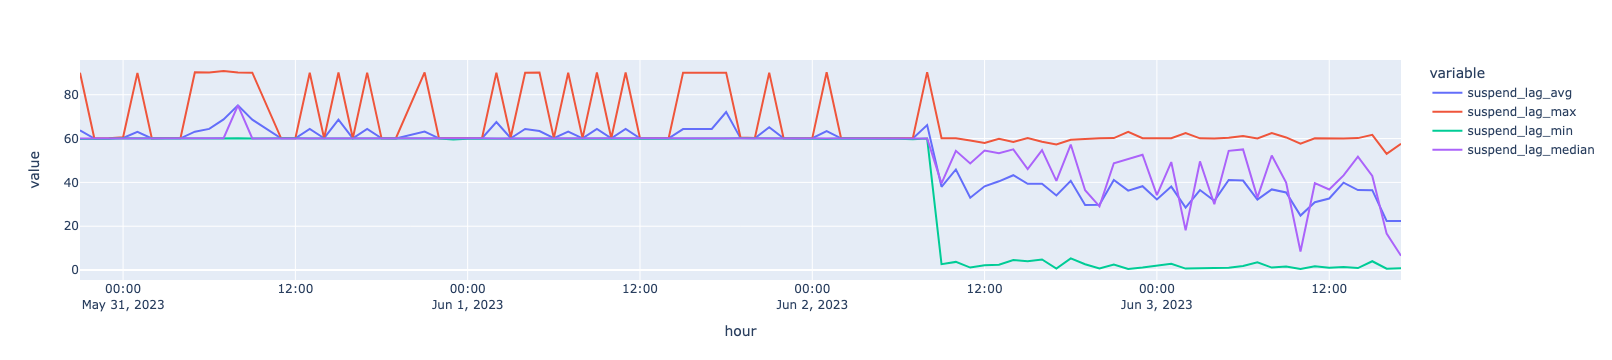

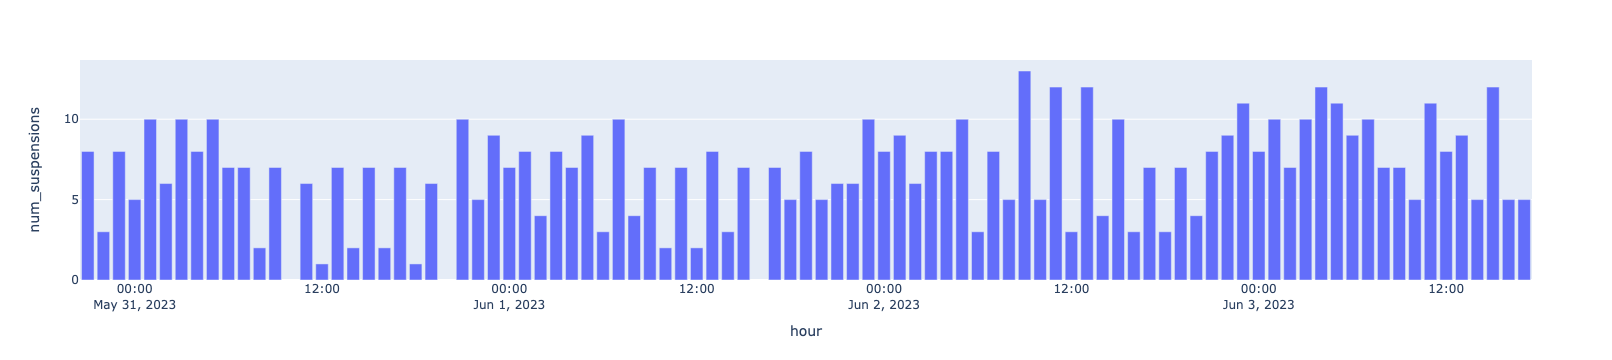

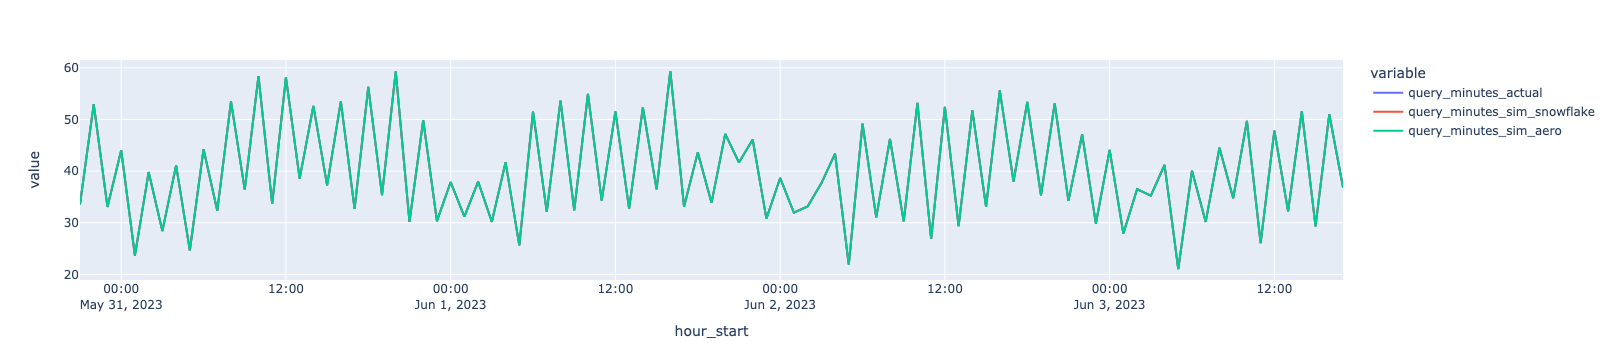

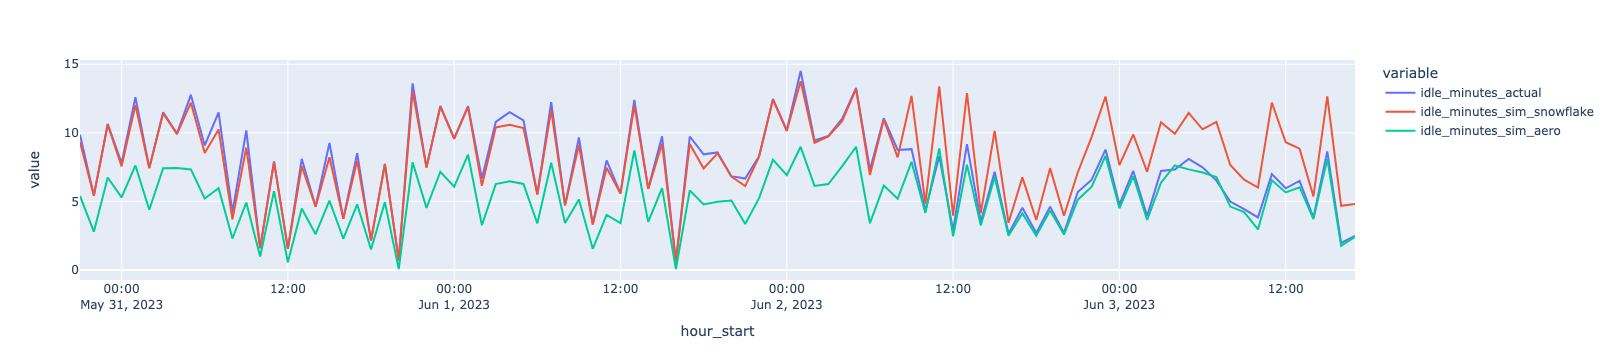

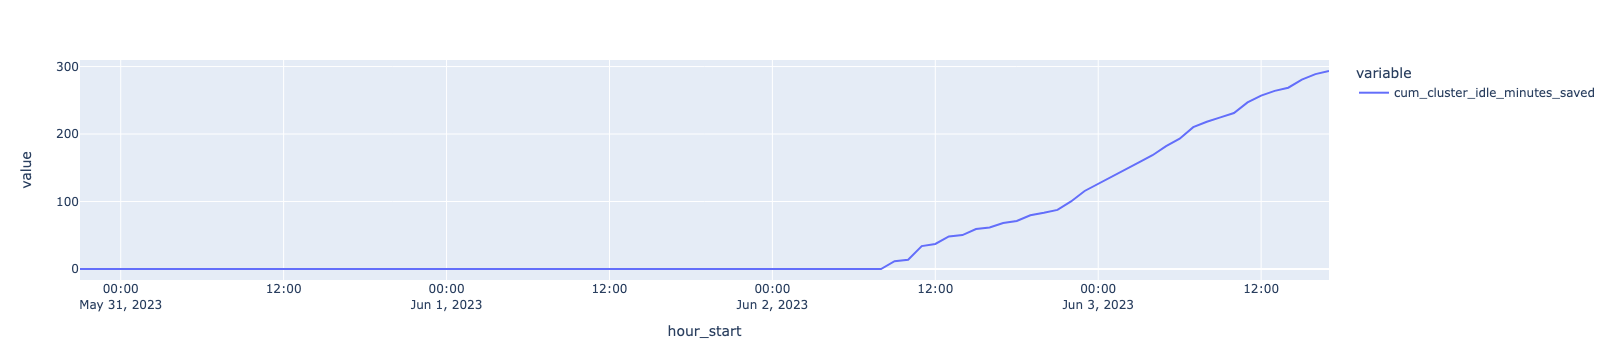

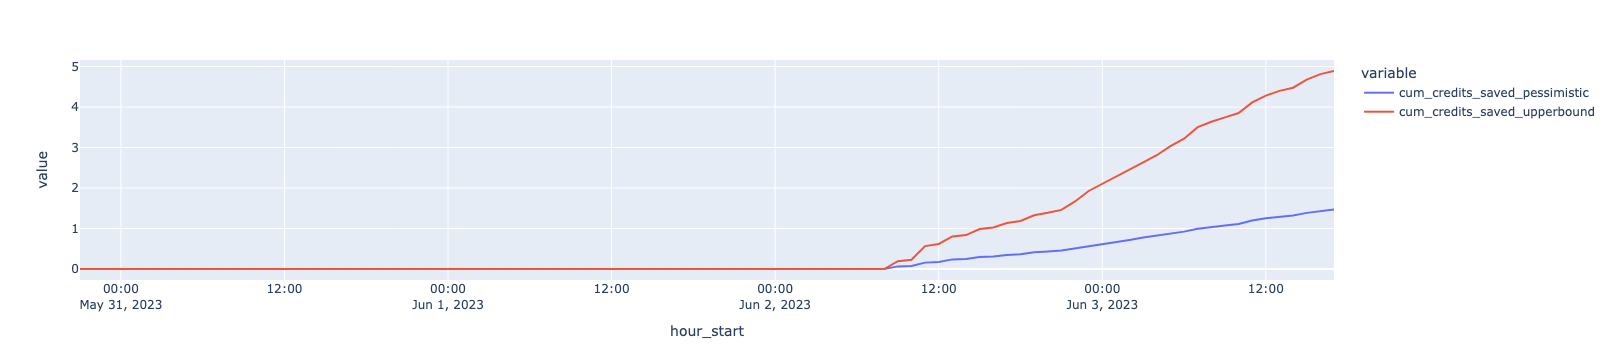

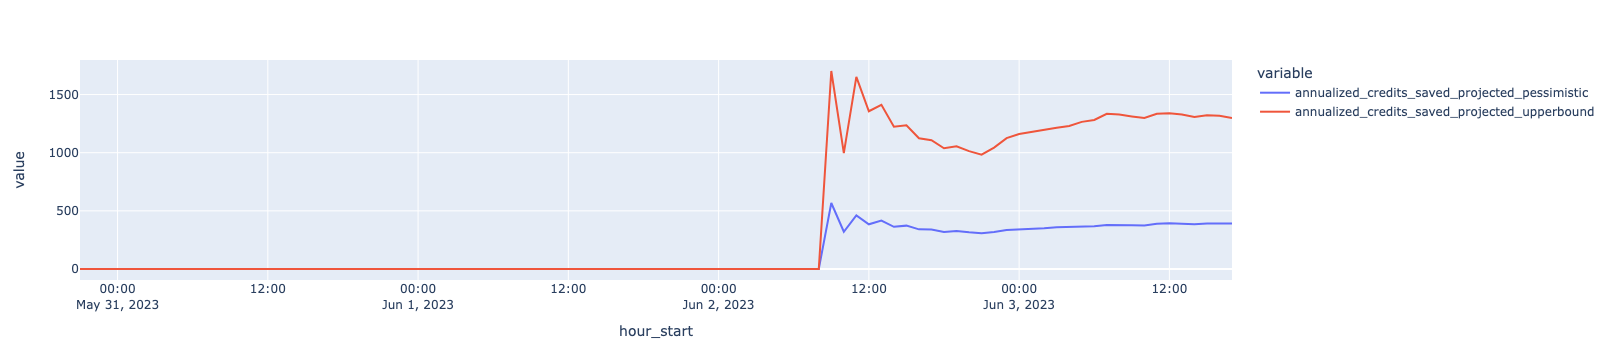

time: 939 ms (started: 2023-06-03 23:57:22 -04:00)


In [18]:
import plotly.express as px
# fig = px.bar(wpdf, x='hour_start', y='dollars_used_compute')
# fig.show()

# fig = px.bar(wpdf, x='hour_start', y=['query_minutes', 'idle_minutes'])
# fig.show()

# fig = px.bar(wpdf, x='hour_start', y='pct_idle')
# fig.show()

# fig = px.scatter(wedf, x="timestamp", y="source")
# fig.show()

# #     cloud_services_cost/credits_used_cloud_services as dollars_per_credit,
# #     sum(credits_used_cloud_services) over (order by start_time asc) cum_credits_used_cloud_services,
# #     sum(query_cost) over (order by start_time asc) cum_query_cost
    
# fig = px.area(opdf, x="start_time", y="cum_query_cost")
# fig.show()

fig = px.line(sdf, x="hour", y=["suspend_lag_avg", 'suspend_lag_max', 'suspend_lag_min', 'suspend_lag_median'])
fig.show()

fig = px.bar(sdf, x="hour", y='num_suspensions')
fig.show()

fig = px.line(wpsimdf, x="hour_start", y=['query_minutes_actual', 'query_minutes_sim_snowflake','query_minutes_sim_aero'])
fig.show()

fig = px.line(wpsimdf, x="hour_start", y=['idle_minutes_actual', 'idle_minutes_sim_snowflake',  'idle_minutes_sim_aero'])
fig.show()


fig = px.line(wpsimdf, x="hour_start", y=['cum_cluster_idle_minutes_saved'])
fig.show()

fig = px.line(wpsimdf, x="hour_start", y=['cum_credits_saved_pessimistic', 'cum_credits_saved_upperbound'])
fig.show()

fig = px.line(wpsimdf, x="hour_start", y=['annualized_credits_saved_projected_pessimistic', 'annualized_credits_saved_projected_upperbound'])
fig.show()



In [39]:
%%markdown
# Latency / Performance

# Latency / Performance


time: 3.24 ms (started: 2023-06-04 00:07:01 -04:00)


In [55]:
whload = f"""
select 
    *
from stg_warehouse_load_history 
where warehouse_name = '{wh_name}' 
    and start_time > dateadd('days',-$lookback_days, current_timestamp())
    order by start_time desc;
"""

load_df = sql_to_df(whload)

whload = f"""
select 
    date_trunc(hour, start_time) start_hour,
    avg(avg_running) as avg_running,
    avg(avg_queued_load) as avg_queued_load,
    avg(avg_queued_provisioning) as avg_queued_provisioning,
    avg(avg_blocked) as avg_blocked
from stg_warehouse_load_history 
where warehouse_name = '{wh_name}' 
    and start_time > dateadd('days',-$lookback_days, current_timestamp())
    group by 1
    order by start_hour desc;
"""

load_hour_df = sql_to_df(whload)

exec_times = f"""

with times as (
    select
        start_time,
        execution_time/1000 as execution_time
    from 
        stg_query_history
    where start_time > dateadd('days',-$lookback_days, current_timestamp())
    and warehouse_name = '{wh_name}'
)
select 
    date_trunc(hour, start_time) as start_hour,
    count(*) as num,
    avg(execution_time) avg,
    median(execution_time) median,
    min(execution_time) min,
    max(execution_time) max,
    percentile_cont(.90) within group(order by execution_time) as "90_pctile",
    percentile_cont(.75) within group(order by execution_time) as "75_pctile",
    percentile_cont(.25) within group(order by execution_time) as "25_pctile",
    percentile_cont(.10) within group(order by execution_time) as "10_pctile"
from
   times
group by 1
having num > 1000
order by 1 desc;
"""
exec_times_df = sql_to_df(exec_times)


time: 3.69 s (started: 2023-06-04 00:21:14 -04:00)


In [28]:
load_df

start_hour     avg_running avg_queued_load  \
0  2023-06-03 16:00:00-07:00  4.657786111167  0.000003333333   
1  2023-06-03 15:00:00-07:00  4.356303888917  0.000041944417   
2  2023-06-03 14:00:00-07:00  5.025312222333  0.000160833333   
3  2023-06-03 13:00:00-07:00  4.741775555500           0E-12   
4  2023-06-03 12:00:00-07:00  4.257670555583  0.000060000000   
..                       ...             ...             ...   
87 2023-05-31 01:00:00-07:00  4.436244444500  0.019315555583   
88 2023-05-31 00:00:00-07:00  5.261682777833  0.000071111083   
89 2023-05-30 23:00:00-07:00  5.347673333417  0.000195277750   
90 2023-05-30 22:00:00-07:00  6.807897500000  0.000208611167   
91 2023-05-30 21:00:00-07:00  4.532870303091  0.000528787818   

   avg_queued_provisioning avg_blocked  
0           0.000848055500       0E-12  
1           0.001179999917       0E-12  
2           0.000526944417       0E-12  
3           0.001496111167       0E-12  
4           0.001626944417       0E-12  
..                     ...         ...  
87          0.001831111083       0E-12  
88          0.000997499917       0E-12  
89          0.001218611167       0E-12  
90          0.000224722167       0E-12  
91          0.000835151455       0E-12  

[92 rows x 5 columns]

time: 9.56 ms (started: 2023-06-04 00:03:29 -04:00)


In [49]:
exec_times_df.avg = exec_times_df.avg.map(float)
exec_times_df.dtypes

start_hour    datetime64[ns, America/Los_Angeles]
num                                         int64
avg                                       float64
median                                    float64
min                                       float64
max                                       float64
90_pctile                                 float64
75_pctile                                 float64
25_pctile                                 float64
10_pctile                                 float64
dtype: object

time: 3.61 ms (started: 2023-06-04 00:17:00 -04:00)


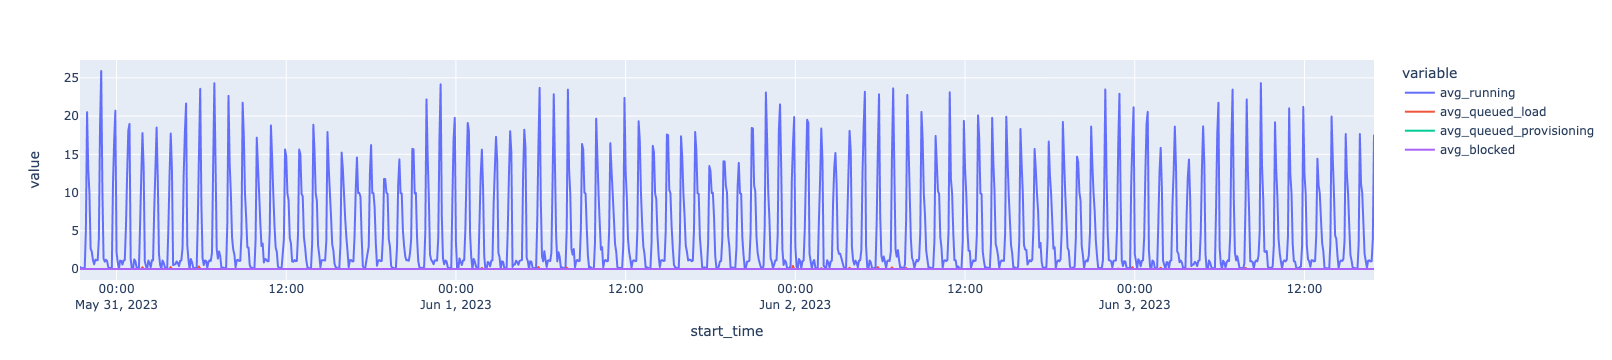

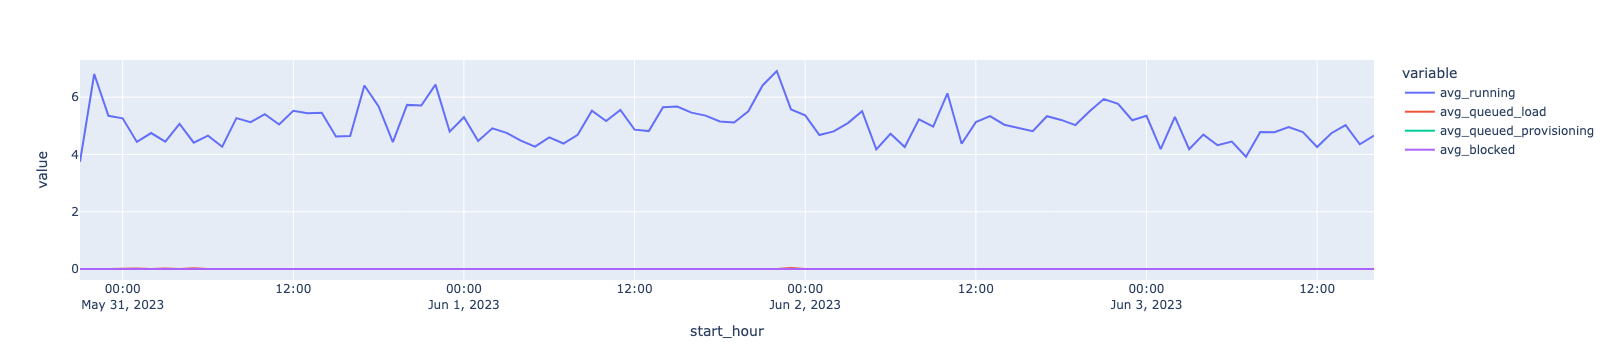

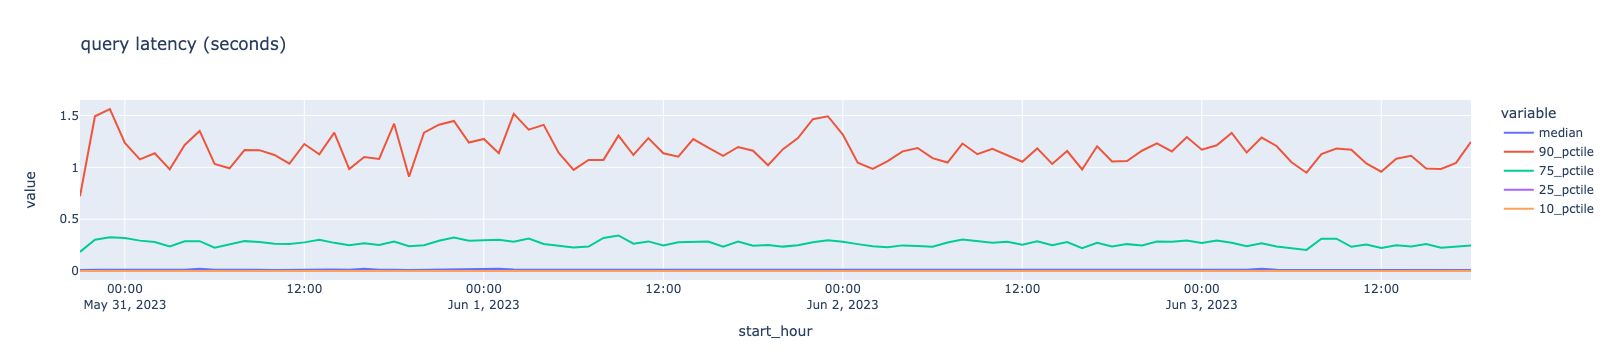

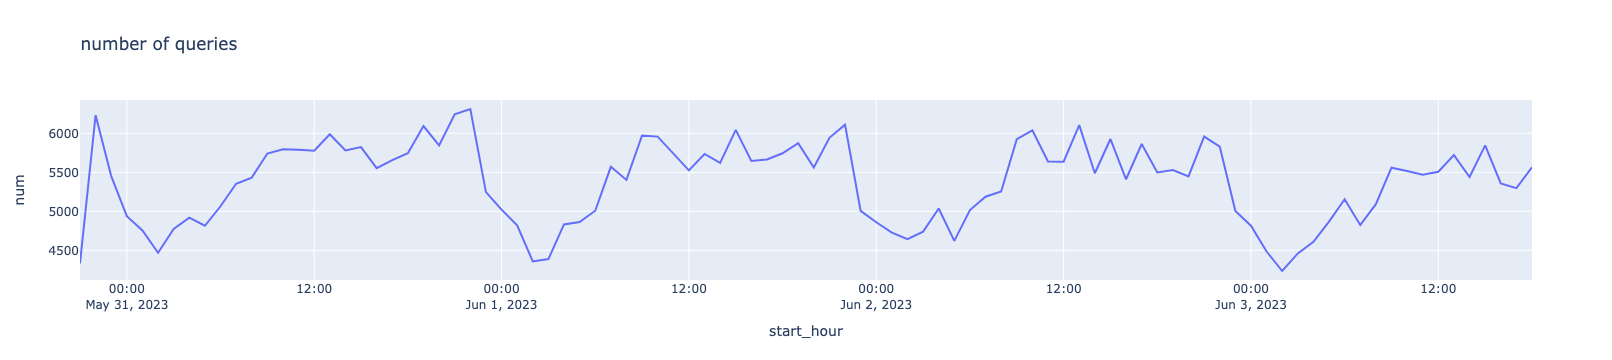

time: 421 ms (started: 2023-06-04 00:21:17 -04:00)


In [56]:
fig = px.line(load_df, x="start_time", y=['avg_running', 'avg_queued_load', 'avg_queued_provisioning', 'avg_blocked'])
fig.show()

fig = px.line(load_hour_df, x="start_hour", y=['avg_running', 'avg_queued_load', 'avg_queued_provisioning', 'avg_blocked'])
fig.show()

fig = px.line(exec_times_df, x="start_hour", y=['median', '90_pctile', '75_pctile', '25_pctile', '10_pctile'], title='query latency (seconds)')
fig.show()
fig = px.line(exec_times_df, x="start_hour", y='num', title='number of queries')
fig.show()


# fig = px.line(wpsimdf, x="hour_start", y=['query_minutes_actual', 'query_minutes_sim_snowflake','query_minutes_sim_aero'])
# fig.show()

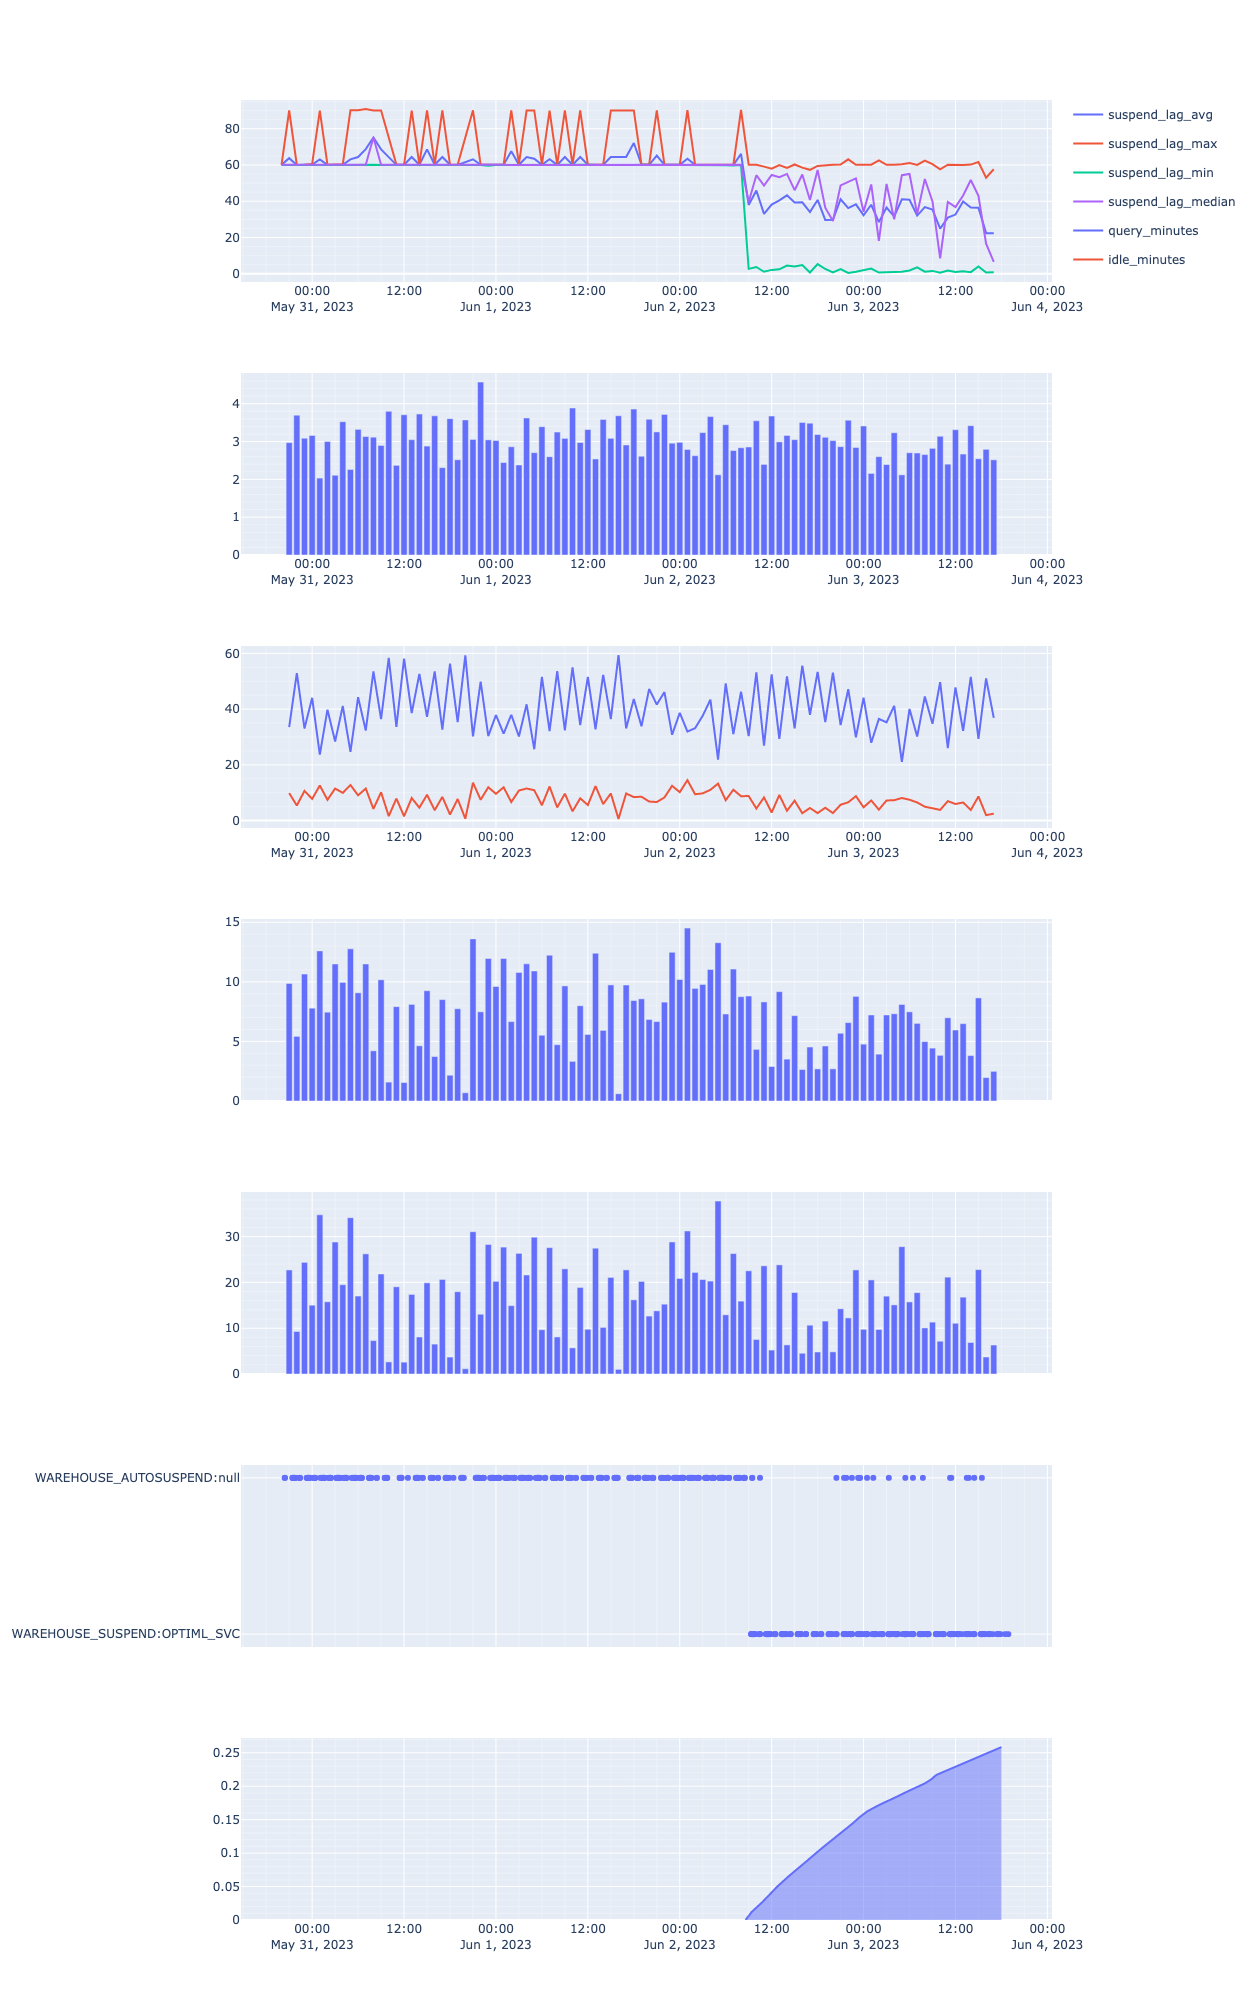

time: 1.26 s (started: 2023-06-03 23:20:34 -04:00)


In [6]:
from plotly.subplots import make_subplots
import plotly.express as px


figures = [
    px.line(sdf, x="hour", y=["suspend_lag_avg", 'suspend_lag_max', 'suspend_lag_min', 'suspend_lag_median']),
    px.bar(wpdf, x='hour_start', y='dollars_used_compute'),
    px.line(wpdf, x='hour_start', y=['query_minutes', 'idle_minutes']),
    px.bar(wpdf, x='hour_start', y= 'idle_minutes'),
    px.bar(wpdf, x='hour_start', y='pct_idle'),
    px.scatter(wedf, x="timestamp", y="source"),
    px.area(opdf, x="start_time", y="cum_query_cost")
    ]

fig = make_subplots(rows=len(figures), cols=1, shared_xaxes=True, vertical_spacing=0.05) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)


fig.update_xaxes(showgrid=True,minor=dict(showgrid=True))
fig.update_yaxes(showgrid=True,minor=dict(showgrid=True))
fig.update_xaxes(autorange=True)
fig.update_layout(xaxis_showticklabels=True, 
                  xaxis2_showticklabels=True,
                 xaxis3_showticklabels=True)

# fig.update_xaxes(range=[df.ts.min(), df.ts.max()])
fig.update_layout(
    height=2000,
)
fig.update_xaxes(type='date', autorange=True)
# fig.update_yaxes(row=3, col=1, autorange='reversed')

fig.show()

# next: try just one layer of test query